In [29]:
import json
import numpy as np
from tqdm.notebook import tqdm
from operator import itemgetter
import re
import pandas as pd
import itertools

import plotly.express as px
import networkx as nx
from matplotlib.pyplot import figure
import matplotlib.pyplot as plt

In [2]:
tag = 'I-LOC'

In [3]:
df = pd.read_csv(f"{tag}.csv")
df.head(2)

,0,1,2,3,4,5,6,7,8,9
0,somalia,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,arizona republic,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [10]:
nested_lst_clean = df.values.tolist()
nested_lst_clean = [[ent for ent in arr if not pd.isnull(ent)] for arr in nested_lst_clean]
nested_lst_clean = [arr for arr in nested_lst_clean if len(arr) > 1]
nested_lst_clean[50:55]

[['usa', 'russia'],
 ['syria', 'turkey'],
 ['israel', 'india', 'hackathon'],
 ['las vegas', 'nv'],
 ['hayward', 'la', 'detroit', 'mi']]

In [17]:
G = nx.Graph()
    
for lst in nested_lst_clean:
    G.add_nodes_from(lst)
    for x, y in itertools.combinations(lst, 2):
        G.add_edges_from([(str(x), str(y))])

In [32]:
from pyvis.network import Network

In [33]:
G_net = Network(height='750px', width='100%', bgcolor='#222222', font_color='white')
for lst in nested_lst_clean:
    G.add_nodes_from(lst)
    for x, y in itertools.combinations(lst, 2):
        G_net.add_node(x, x, title=x)
        G_net.add_node(y, y, title=y)
        G_net.add_edge(x, y, value=1)

In [34]:
G_net.show('loc_network.html')

## Degree Distribution

In [25]:
degree_sequence = sorted([d for n, d in G.degree()], reverse=True)
fig = px.histogram(degree_sequence)
fig.update_layout(
    xaxis_title="Degree",
    yaxis_title="Count",
    title="Distribution of Degrees in the Localisation Graph",
)
fig.show()

## Is the Network Scale-Free?

In [26]:
import powerlaw

Calculating best minimal value for power law fit


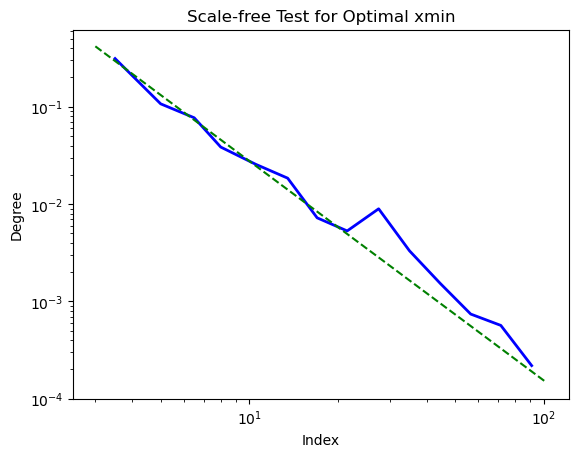

In [31]:
fit = powerlaw.Fit(degree_sequence) 
# x_min is calculated based on Kolmogorov-Smirnov distance
fig = fit.plot_pdf(color='b', linewidth=2, )
fit.power_law.plot_pdf(color='g', linestyle='--', ax=fig)
plt.xlabel("Index")
plt.ylabel("Degree")
plt.title('Scale-free Test for Optimal xmin')
plt.show()

## Connected Components

In [51]:
len(max(nx.connected_components(G), key=len)), [len(c) for c in sorted(nx.connected_components(G), key=len, reverse=True)][1]

(1183, 5)

In [41]:
hub = G.subgraph(max(nx.connected_components(G), key=len))

## PageRank

In [55]:
G_pagerank = nx.pagerank(G)
G_sorted_nodes = sorted([(node, pagerank) for node, pagerank in G_pagerank.items()], key=lambda x : G_pagerank[x[0]], reverse=True)
G_sorted_nodes

[('america', 0.012296916807835493),
 ('russia', 0.010223253961119807),
 ('florida', 0.009557001837796255),
 ('syria', 0.008898512288807869),
 ('israel', 0.007697499624343913),
 ('iran', 0.0074827198660928585),
 ('ohio', 0.007085278846134409),
 ('texas', 0.007038885124991073),
 ('us', 0.0063729446321869315),
 ('iraq', 0.0061656330514126695),
 ('clinton', 0.0059597810171452496),
 ('mexico', 0.005515826332424661),
 ('europe', 0.005500336703980617),
 ('germany', 0.005497021994124882),
 ('usa', 0.005205530879746581),
 ('france', 0.005056964657062922),
 ('trump', 0.004982291332626067),
 ('china', 0.004592379814658067),
 ('california', 0.0041690462746882834),
 ('haiti', 0.004140430666087317),
 ('ukraine', 0.004119827293483571),
 ('cleveland', 0.004117062741496715),
 ('pennsylvania', 0.004033157432213241),
 ('michigan', 0.004017210554230616),
 ('turkey', 0.003960213076456805),
 ('allafrica', 0.003942503383108634),
 ('chicago', 0.003934765113799562),
 ('africa', 0.003909461433692518),
 ('bengha

## Communities

In [82]:
from networkx.algorithms import community

In [119]:
c = community.greedy_modularity_communities(hub)
print([len(c[k]) for k in range(len(c))])
print(len(c))

[288, 220, 171, 142, 97, 36, 36, 31, 27, 27, 22, 16, 9, 8, 5, 5, 5, 5, 4, 4, 4, 3, 3, 3, 3, 3, 3, 3]
28


In [120]:
labels = {}
grouped_labels = community.louvain_communities(hub)
for k, com in enumerate(grouped_labels):
    for idx in com:
        labels[idx] = k + 1
print(sorted([len(s) for s in grouped_labels], reverse=True))
print(len(grouped_labels))

[181, 163, 91, 78, 73, 62, 58, 57, 56, 54, 52, 48, 46, 37, 34, 29, 25, 23, 12, 4]
20


In [121]:
sorted_labels = [labels[node] for node in hub.nodes]

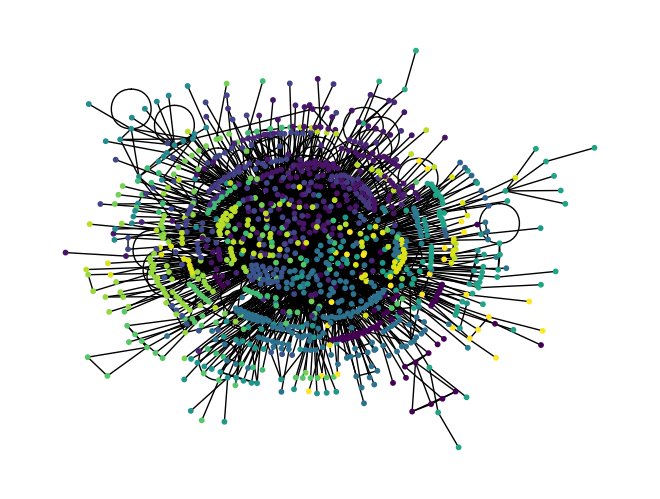

In [122]:
nx.draw_kamada_kawai(hub, node_size=10, node_color=sorted_labels)

In [128]:
for s in c:
    if "america" in s:
        america_nodes = list(s)

In [129]:
america_hub = hub.subgraph(america_nodes)

In [131]:
america_net = Network(height='750px', width='100%', bgcolor='#222222', font_color='white')
america_net.from_nx(america_hub)
america_net.show("america_network.html")

## Number of Twitter Trolls Who Mentioned the Community

In [132]:
with open("parsed_tweets.json") as f:
    parsed_tweets = json.load(f)

In [142]:
community_tweets = {}
for tweet in parsed_tweets:
    for entity in tweet["entities"]:
        if any([(ent.lower() in america_nodes) for ent in entity["entity"]]):
            community_tweets[tweet["tweet_id"]] = tweet

In [143]:
len(community_tweets)

6452

In [148]:
unique_trolls = set([community_tweets[tweet]["user_id"] for tweet in community_tweets])

In [152]:
unique_trolls_count = {k: 0 for k in unique_trolls}
for tweet in community_tweets:
    user = community_tweets[tweet]["user_id"]
    if user in unique_trolls:
        unique_trolls_count[user] += 1

In [160]:
sorted_unique_trolls_count = {k: v for k, v in sorted(unique_trolls_count.items(), key=lambda item: item[1], reverse=True)}
sorted_unique_trolls_count

{1679279490.0: 421,
 nan: 291,
 1671234620.0: 278,
 4224729994.0: 194,
 2671070290.0: 166,
 1617939218.0: 140,
 1710804738.0: 125,
 1694026190.0: 125,
 1690487623.0: 123,
 1833223908.0: 122,
 1649967228.0: 119,
 1660771422.0: 117,
 3990577513.0: 112,
 1655194147.0: 111,
 1676481360.0: 106,
 2572058134.0: 105,
 2533221819.0: 105,
 1623180199.0: 103,
 1658202894.0: 99,
 2540882036.0: 93,
 2533653547.0: 92,
 1656685598.0: 90,
 1868981054.0: 81,
 1661246144.0: 78,
 1649487510.0: 77,
 1768259989.0: 77,
 3084360275.0: 73,
 1868496344.0: 73,
 1680366068.0: 73,
 2606301939.0: 70,
 4508630900.0: 69,
 4272870988.0: 68,
 1659549972.0: 67,
 2590038478.0: 66,
 2587100717.0: 63,
 1658420976.0: 63,
 1662779209.0: 63,
 1657753759.0: 61,
 3084088366.0: 57,
 1684524144.0: 57,
 1649144358.0: 46,
 1646999972.0: 43,
 2547141851.0: 41,
 2491081213.0: 39,
 2882013788.0: 38,
 2535166748.0: 38,
 3083844539.0: 38,
 1651693646.0: 37,
 4332740714.0: 36,
 1533813962.0: 36,
 4355797094.0: 35,
 2753211010.0: 33,
 25

In [162]:
users = pd.read_csv("data/users.csv")
users.head(2)

,id,location,name,followers_count,statuses_count,time_zone,verified,lang,screen_name,description,created_at,favourites_count,friends_count,listed_count
0,100345056.0,still ⬆️Block⤵️Corner⬇️street,#Ezekiel2517✨...,1053.0,31858.0,NaN,False,en,SCOTTGOHARD,CELEBRITY TRAINER ✨#424W147th✨ #CrossfitCoach ...,Tue Dec 29 23:15:22 +0000 2009,2774.0,1055.0,35.0
1,247165706.0,"Chicago, IL",B E C K S T E R✨,650.0,6742.0,Mountain Time (US & Canada),False,en,Beckster319,Rebecca Lynn Hirschfeld Actress.Model.Writer.A...,Fri Feb 04 06:38:45 +0000 2011,7273.0,896.0,30.0


In [181]:
top_trolls = pd.DataFrame([
    {
        "id": idx,
        "name": users.loc[users['id'] == idx]["name"].values,
        "followers_count": users.loc[users['id'] == idx]["followers_count"].values,
        "tweets_count": sorted_unique_trolls_count[idx]
    } for idx in sorted_unique_trolls_count
])

In [182]:
top_trolls.head(12)

,id,name,followers_count,tweets_count
0,1.679279e+09,[Amelie Baldwin],[2464.0],421
1,NaN,[],[],291
2,1.671235e+09,[Susan],[2225.0],278
3,4.224730e+09,[nan],[nan],194
4,2.671070e+09,[Blake Cline],[2035.0],166
5,1.617939e+09,[Pauline Gunn],[908.0],140
6,1.710805e+09,[Steven Cook],[1468.0],125
7,1.694026e+09,[Jackie Best],[2078.0],125
8,1.690488e+09,[Michelle Arrington],[3229.0],123
9,1.833224e+09,[Dorothie],[1893.0],122
